# Logistic Regression

## Importing the libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the dataset

In [20]:
df = pd.read_csv('/content/breast_cancer.csv')
df.drop(columns=['Sample code number'], inplace=True)

In [21]:
df.isnull().sum()

,0
Clump Thickness,0
Uniformity of Cell Size,0
Uniformity of Cell Shape,0
Marginal Adhesion,0
Single Epithelial Cell Size,0
Bare Nuclei,0
Bland Chromatin,0
Normal Nucleoli,0
Mitoses,0
Class,0


In [22]:
df.columns

Index(['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses', 'Class'],
      dtype='object')

##Data Visualization

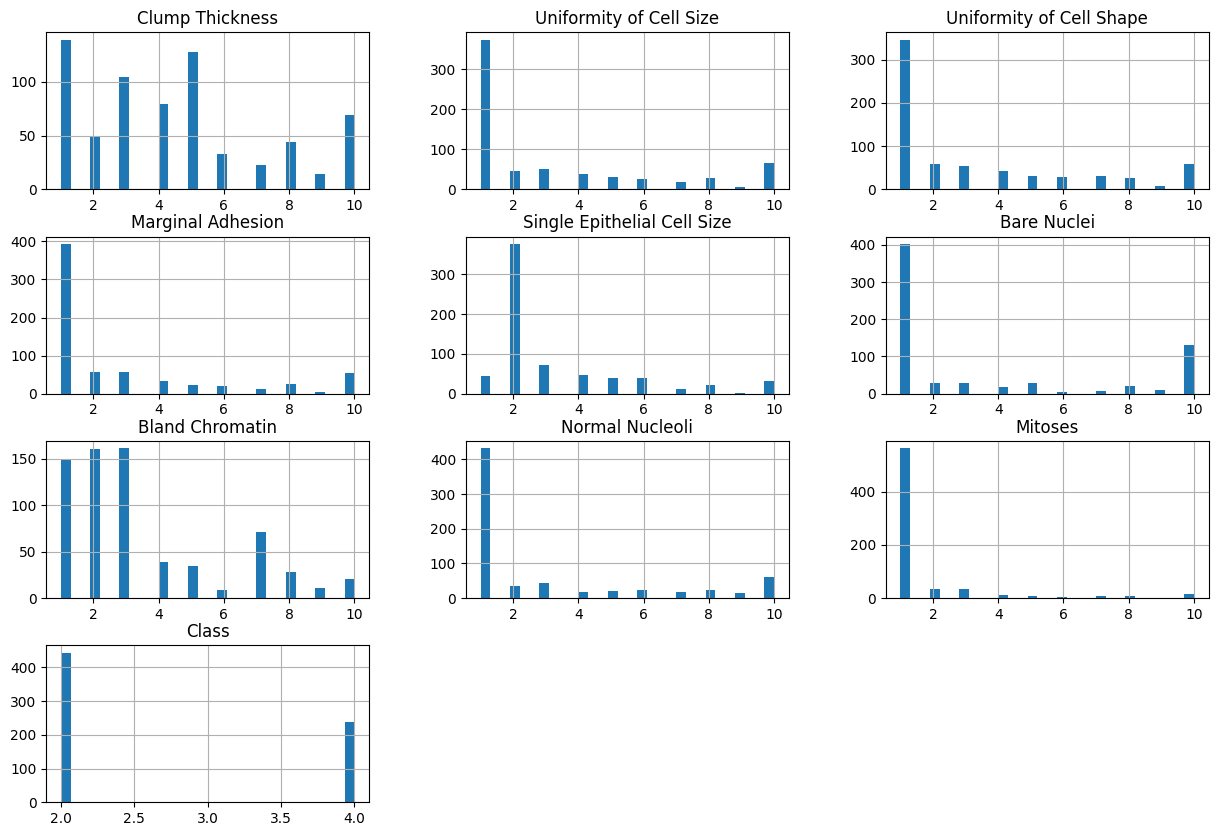

In [23]:
df.hist(bins=30, figsize=(15, 10))
plt.show()

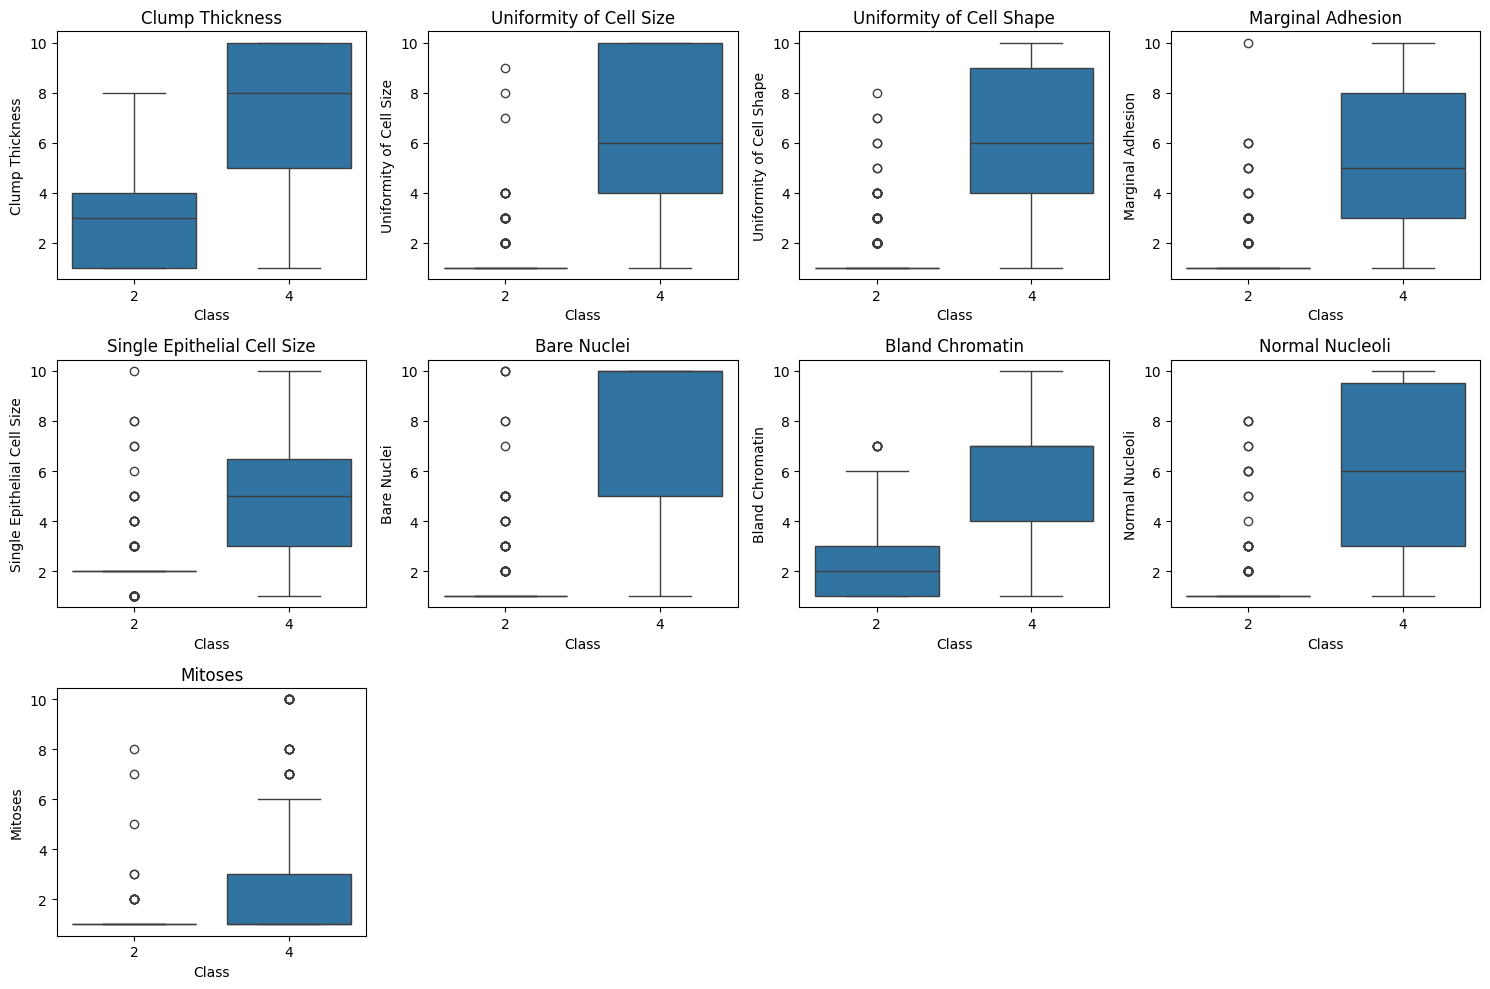

In [24]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x='Class', y=column, data=df)
    plt.title(column)
plt.tight_layout()
plt.show()

##MultiCollinearity Analysis and Fixation

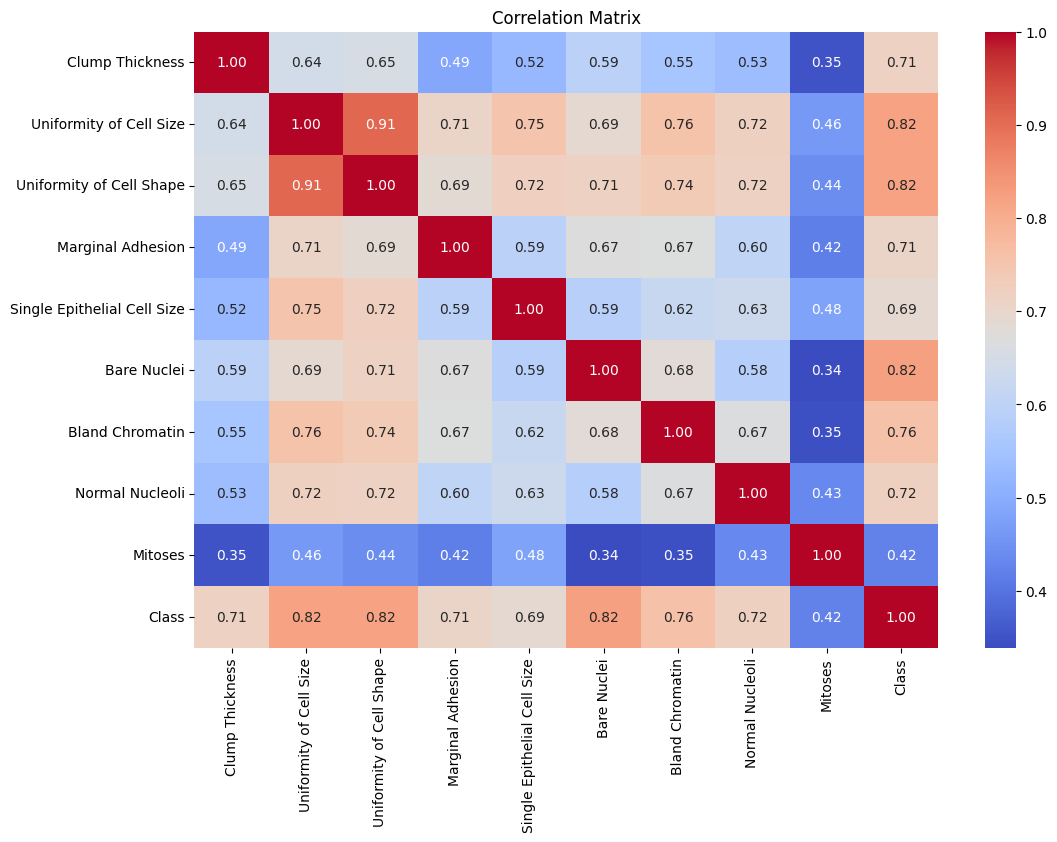

In [25]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [26]:
df['Class'] = df['Class'].map({4: 1, 2: 0})

In [27]:
feature_names = df.columns[:-1]
print(feature_names)

Index(['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses'],
      dtype='object')


We will exclude feature 'Uniformity of Cell Size' beacuse it is highly correlated with Uniformity of Cell Shape feature.

In [28]:
X = df.drop(columns=['Uniformity of Cell Size']).iloc[:,:-1].values
y = df.iloc[:, -1].values

In [29]:
X[0]

array([5, 1, 1, 2, 1, 3, 1, 1])

###Statsmodel Summary

We are using Statsmodel Summary of features on logistic regression to figure out there p values and R-Squared value of overall model. With this information we can perform Feature Selection Based on some Pvalue < Threshold

In [30]:
import statsmodels.api as sm
X_sm = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X_sm).fit()

# Print the summary which includes p-values
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.075321
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  683
Model:                          Logit   Df Residuals:                      674
Method:                           MLE   Df Model:                            8
Date:                Fri, 23 Aug 2024   Pseudo R-squ.:                  0.8837
Time:                        14:19:04   Log-Likelihood:                -51.445
converged:                       True   LL-Null:                       -442.18
Covariance Type:            nonrobust   LLR p-value:                2.036e-163
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.0976      1.155     -8.739      0.000     -12.362      -7.833
x1             0.5346      0

###Variance Inflation Factor(VIF)

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add a constant for intercept term
X_with_const = sm.add_constant(df.drop(columns=['Class','Uniformity of Cell Size']))

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print(vif_data)

                       Feature       VIF
0                        const  4.812578
1              Clump Thickness  1.888002
2     Uniformity of Cell Shape  3.990194
3            Marginal Adhesion  2.414223
4  Single Epithelial Cell Size  2.402298
5                  Bare Nuclei  2.594098
6              Bland Chromatin  2.777077
7              Normal Nucleoli  2.416644
8                      Mitoses  1.393591


## Splitting the dataset into the Training set and Test set

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [33]:
from sklearn.model_selection import train_test_split
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size = 0.2, random_state = 0)

## Training the Logistic Regression model on the Training set

In [34]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train_pca, y_train)

LogisticRegression(random_state=0)

## Predicting the Test set results

In [47]:
y_pred = classifier.predict(X_test_pca)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[:10])
#This prints results of first ten observations side by side. Left Side is the Predicted Class and Right Side is Actual Class

[[0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]]


##Plotting Decision Boundary

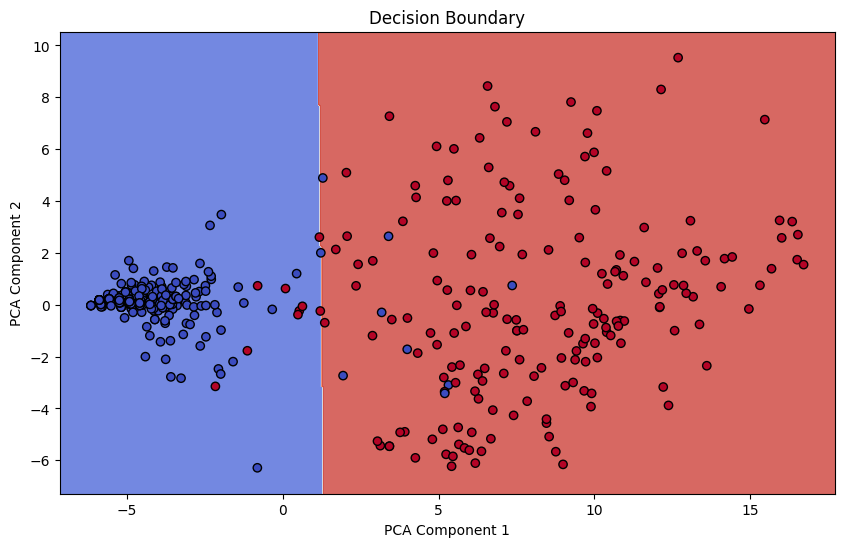

In [36]:
# Plot decision boundary
xx, yy = np.meshgrid(np.linspace(X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1, 500),
                     np.linspace(X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1, 500))

# Predict class labels
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolor='k', marker='o', cmap='coolwarm')
plt.title('Decision Boundary')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## Making the Confusion Matrix

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score
cf = confusion_matrix(y_test, y_pred) #normalize= 'pred' can be used to see accuracy for each class
print(cf)

[[84  3]
 [ 2 48]]


In [38]:
cf = confusion_matrix(y_test, y_pred, normalize='pred')
print(cf)

[[0.97674419 0.05882353]
 [0.02325581 0.94117647]]


In [39]:
y_pred_train=classifier.predict(X_train_pca)

In [40]:
print(accuracy_score(y_test,y_pred)) #accuracy on test set

0.9635036496350365


In [41]:
print(accuracy_score(y_train,y_pred_train)) #accuracy on Training Set

0.967032967032967


##Plotting ROC Curve

In [42]:
y_pred_proba = classifier.predict_proba(X_test_pca)[:, 1] #This returns Predicted probabilities for each row

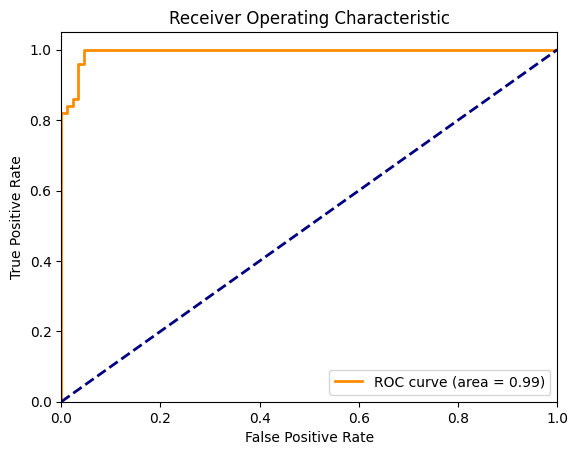

In [43]:
from sklearn.metrics import roc_curve, auc

# Assuming `y_test` and `y_pred_proba` are your true labels and predicted probabilities
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

ROC curve has AUC(area under curve) equal to 1 which is ideal for classification

##Classification Report to Observe Overfitting

In [44]:
from sklearn.metrics import classification_report

# Evaluate on training set
y_train_pred_proba = classifier.predict_proba(X_train_pca)[:, 1]
print('Training Set Classification Report:')
print(classification_report(y_train, classifier.predict(X_train_pca)))

# Evaluate on test set
y_test_pred = classifier.predict(X_test_pca)
print('Test Set Classification Report:')
print(classification_report(y_test, y_test_pred))

Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       357
           1       0.95      0.95      0.95       189

    accuracy                           0.97       546
   macro avg       0.96      0.96      0.96       546
weighted avg       0.97      0.97      0.97       546

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        87
           1       0.94      0.96      0.95        50

    accuracy                           0.96       137
   macro avg       0.96      0.96      0.96       137
weighted avg       0.96      0.96      0.96       137



The Accuracy on Test Set (96%) and Training Set (96%) suggest that there is no overfitting since the difference between accuracy scores is very very less.

## Computing the accuracy with k-Fold Cross Validation

In [45]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train_pca, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 96.70 %
Standard Deviation: 2.28 %
